# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [1]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)

    def to_tensor(self):
        return torch.tensor([self.x_min, self.y_min, self.x_max, self.y_max])


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [2]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

11501568/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas (rotated digits have additional *added to description).

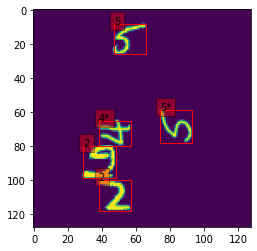

In [3]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

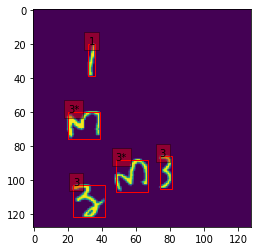

In [4]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis

In [5]:
import collections
import matplotlib.pyplot as plt
import math


ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

unique_sizes = set()
for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        # I don't want squares because they can confuse rotation detection in NN
        if abs(box.x_diff - box.y_diff) == 0:
            continue
        unique_sizes.add((min(box.x_diff, box.y_diff), max(box.x_diff, box.y_diff)))
        unique_sizes.add((max(box.x_diff, box.y_diff), min(box.x_diff, box.y_diff)))

ANCHOR_SIZES = list(unique_sizes)
ANCHOR_SIZES.sort()
# I get every second unique anchor size because 35 anchor sizes was a bit too much
ANCHOR_SIZES = ANCHOR_SIZES[::2]
print(len(ANCHOR_SIZES), ANCHOR_SIZES)

17 [(2, 19), (4, 19), (6, 19), (8, 19), (10, 19), (12, 19), (14, 19), (16, 19), (18, 19), (19, 3), (19, 5), (19, 7), (19, 9), (19, 11), (19, 13), (19, 15), (19, 17)]


### Model building

In [6]:
ANCHORS = []
for i in range(16):
    y = (i + 0.5) * 8
    for j in range(16):
        x = (j + 0.5) * 8
        for size in ANCHOR_SIZES:
            x_min = max(0, x - (size[0] + 1) // 2)
            x_max = min(128, x + (size[0] + 1) // 2)

            y_min = max(0, y - (size[1] + 1) // 2)
            y_max = min(128, y + (size[1] + 1) // 2)
            ANCHORS.append(MnistBox(x_min, y_min, x_max, y_max))

print(len(ANCHORS))

4352 4352


In [7]:
from torch import nn


class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux

In [52]:
# I have applied the same layers to each of the heads, assuming sigmoid(x) would
# give accurate percentages when asked.
def make_layers(out_planes):
    return torch.nn.Sequential(
        torch.nn.Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
        torch.nn.ReLU(),
        torch.nn.Conv2d(96, len(ANCHOR_SIZES) * out_planes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),
                        bias=True),
    )

class DigitClassificationHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Extremely important step to make layers in init, otherwise weights 
        # would be generated all over again when it would be in forward
        self.block = make_layers(5)
        
    def forward(self, x):
        # Permuting because our input isn't of shape (1, 16, 16, 128)
        # but (1, 128, 16, 16)
        x = self.block(x).permute(0, 2, 3, 1).reshape(-1, 5)
        return x

class RotationClassificationHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block = make_layers(2)
        
    def forward(self, x):
        x = self.block(x).permute(0, 2, 3, 1).reshape(-1, 2)
        return x

class BoxRegressionHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block = make_layers(4)
        
    def forward(self, x):
        x = self.block(x).permute(0, 2, 3, 1).reshape(-1, 4)
        return x

In [9]:
class DigitDetectionModel(torch.nn.Module):
    def __init__(
        self,
        anchors,
        backbone,
        digit_classification_head,
        rotation_classification_head,
        box_regression_head):

        super().__init__()
        self.anchors = anchors
        self.backbone = backbone
        self.digit_classification_head = digit_classification_head
        self.rotation_classification_head = rotation_classification_head
        self.box_regression_head = box_regression_head
        

    # Model forward just consists of forwarding backbone and each of the heads
    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        bb_out = self.backbone(x)
        d_out = self.digit_classification_head(bb_out)
        r_out = self.rotation_classification_head(bb_out)
        b_out = self.box_regression_head(bb_out)

        return DigitDetectionModelOutput(
            # I do not change anchors thus I return them untouched
            anchors = self.anchors,
            digit_classification_output = d_out,
            rotation_classification_output = r_out,
            box_regression_output = b_out,
        )

### Significant overlap

In [31]:
from torchvision.ops import box_iou, nms
import copy


class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
        # Those tensors will be used in constructing DigitDetectionModelTarget output
        digit_class_target = torch.zeros(len(anchors), nb_of_classes, device=DEVICE)
        rot_class_target = torch.zeros(len(anchors), 2, device=DEVICE)
        box_reg_target = torch.zeros(len(anchors), 4, device=DEVICE)

        gt_boxes = canvas.boxes
        matched_anchs = []
        for idx, box in enumerate(anchors):
            gt_best = None
            max_iou = 0.0
            # Finding best ground truth box for each of the anchors
            for gt_box in gt_boxes:
                iou = gt_box.iou_with(box)
                if iou > max(iou_threshold, max_iou):
                    gt_best = copy.deepcopy(gt_box)
                    max_iou = iou

            # If best ground truth box was found
            if gt_best is not None:
                box_reg_target[idx, 0] = gt_best.x_min - box.x_min
                box_reg_target[idx, 1] = gt_best.x_max - box.x_max
                box_reg_target[idx, 2] = gt_best.y_min - box.y_min
                box_reg_target[idx, 3] = gt_best.y_max - box.y_max
                
                digit_class_target[idx, gt_best.class_nb - 1] = 1

                if gt_best.rotated:
                    rot_class_target[idx, 1] = 1
                else:
                    rot_class_target[idx, 0] = 1
                
                matched_anchs.append(idx)
        
        return DigitDetectionModelTarget(
            digit_classification_target = digit_class_target,
            rotation_classification_target = rot_class_target,
            box_regression_target = box_reg_target,
            matched_anchors = matched_anchs,
        )

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        
        # Threshold for torchvision.ops.nms to eliminate close to each other boxes
        BOXES_THRESHOLD = 0.15
        # Threshold for prediction certainty
        PRED_THRESHOLD = 0.2

        model_anchors = model_output.anchors
        # Getting most probable digits and their scores for each anchor
        scores, digits = model_output.digit_classification_output.max(dim=-1)
        boxes = torch.stack([model_anchors[idx].to_tensor() for idx in range(len(model_anchors))]).to(DEVICE)

        # Removing redundant anchors
        filtered_boxes = torchvision.ops.nms(boxes.float(), scores, iou_threshold=BOXES_THRESHOLD)

        # Percentage of digit certainty for each anchor
        dig_pred = torch.sigmoid(scores)

        rot_pred = model_output.rotation_classification_output
        box_pred = model_output.box_regression_output

        candidates = []
        best_scores = []
        bounds = []
        for idx in filtered_boxes:
            if dig_pred[idx].item() > PRED_THRESHOLD:
                box = copy.deepcopy(model_anchors[idx])
                box.x_min += box_pred[idx, 0]
                box.x_max += box_pred[idx, 1]
                box.y_min += box_pred[idx, 2]
                box.y_max += box_pred[idx, 3]

                box.class_nb = digits[idx] + 1
                if torch.sigmoid(rot_pred[idx, 1]) > torch.sigmoid(rot_pred[idx, 0]):
                    box.rotated = True
                else:
                    box.rotated = False

                candidates.append(box)
                best_scores.append(dig_pred[idx].item())
                bounds.append(box.to_tensor())
            
        if len(candidates) == 0:
            return []
        
        # Doing torchvision.ops.nms because of the possible movement of anchors
        # due to box_pred tensor
        output = torchvision.ops.nms(torch.stack(bounds), torch.FloatTensor(best_scores), BOXES_THRESHOLD)
        answer = [candidates[idx] for idx in output]

        return answer

### Metrics

In [36]:
import torch
import torchvision 


class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        
        if len(model_target.matched_anchors) == 0:
            return None
        
        # Getting boxes only on matched anchors
        matched_anch_idx = torch.stack(model_target.matched_anchors)
        box_target = model_target.box_regression_target[matched_anch_idx]
        box_out = model_output.box_regression_output[matched_anch_idx]

        # Loss over boxes on matched anchors
        reg_loss = torch.nn.SmoothL1Loss(reduction='mean')
        box_loss = reg_loss(
            box_out,
            box_target
        )

        # Loss over digit predictions over all anchors
        digit_loss = torchvision.ops.sigmoid_focal_loss(
            model_output.digit_classification_output,
            model_target.digit_classification_target,
            reduction='mean'
        )

        # Loss over rotation predictions over all anchors
        rot_loss = torchvision.ops.sigmoid_focal_loss(
            model_output.rotation_classification_output,
            model_target.rotation_classification_target,
            reduction='mean'
        )

        total_loss = box_loss + digit_loss + rot_loss

        return total_loss


class DigitAccuracy:

    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        canvas_boxes = canvas.boxes
        if len(canvas_boxes) != len(predicted_boxes):
            return 0
        
        for gt_box in canvas_boxes:
            matches = 0
            for pr_box in predicted_boxes:
                iou = pr_box.iou_with(gt_box)
                # Checking if given predicted box meets threshold of being accepted as valid
                if iou > 0.5 and pr_box.class_nb == gt_box.class_nb and gt_box.rotated == pr_box.rotated:
                    matches += 1
            if matches == 0 or matches > 1:
                return 0
        # Function goes here when every of the canvas boxes has exactly one 
        # good predicted box
        return 1

### Model training

In [33]:
from torch.utils.data import Dataset, DataLoader

class CanvasDataset(Dataset):

    def __init__(self, length, all_anchors):
        self.canvases = [get_random_canvas() for _ in range(length)]
        self.targets = [TargetDecoder().get_targets(cur_canvas, all_anchors) for cur_canvas in self.canvases]

    def __len__(self):
        return len(self.canvases)

    def __getitem__(self, idx):
        img = self.canvases[idx].image
        box_target = self.targets[idx].box_regression_target
        digit_class_target = self.targets[idx].digit_classification_target
        rot_class_target = self.targets[idx].rotation_classification_target
        matched_anchors = self.targets[idx].matched_anchors

        return {'img': img, 'box_target': box_target, 'digit_class_target': digit_class_target,
                'rot_class_target': rot_class_target, 'matched_anchors': matched_anchors}

In [13]:
train_dataset = CanvasDataset(1000, ANCHORS)
train_loader = DataLoader(train_dataset, batch_size=1,
                          shuffle=False, num_workers=0)

test_dataset = [get_random_canvas() for _ in range(100)]

In [34]:
import torch.optim as optim

class Learner:
    def __init__(self, my_model, loss, train_loader, test_dataset):
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        
        self.model = my_model
        self.loss = loss
        self.train_loader = train_loader
        self.test_dataset = test_dataset
    
    def process_loader_data(self, data):
        img = data['img'].squeeze().float()
        box_target = data['box_target'].squeeze().to(self.device)
        digit_class_target = data['digit_class_target'].squeeze().to(self.device)
        rot_class_target = data['rot_class_target'].squeeze().to(self.device)
        matched_anchors_idx = data['matched_anchors']
        
        input = MnistCanvas(img, [])
        target = DigitDetectionModelTarget(digit_class_target, rot_class_target,
                                            box_target, matched_anchors_idx)
        return (input, target)
        

    def train(self, epochs, sim_batch_size, lr):
        net = self.model.to(self.device)
        optimizer = optim.Adam(net.parameters(), lr=lr)

        for idx in range(epochs):
            print("EPOCH", idx)
            net.train()
            loss_sum = 0
            loss = 0.0
            for batch_idx, data in enumerate(self.train_loader):
                Input, Target = self.process_loader_data(data)
                
                output = net(Input)
                curr_loss = self.loss.compute_loss(output, Target)
                loss += curr_loss
                
                # I simulate batching by counting loss every sim_batch_size cases
                if (batch_idx + 1) % sim_batch_size == 0:
                    print("BATCH LOSS", loss, "PER EXAMPLE LOSS", loss / sim_batch_size)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    loss = 0
                
                loss_sum += curr_loss

            
            print("EPOCH LOSS", loss_sum / len(self.train_loader))

            net.eval()
            correct = 0
            for canvas in self.test_dataset:
                output = net(canvas)

                correct += DigitAccuracy().compute_metric(TargetDecoder().get_predictions(output), canvas)
            print("ACCURACY", correct / len(self.test_dataset))

In [37]:
import torch.optim as optim
from torch import nn

model = DigitDetectionModel(
    backbone=Backbone(),
    digit_classification_head=DigitClassificationHead(),
    rotation_classification_head=RotationClassificationHead(),
    box_regression_head=BoxRegressionHead(),
    anchors=ANCHORS,
)

learner = Learner(model, RetinaLoss(), train_loader, test_dataset)
learner.train(epochs=100, sim_batch_size=250, lr=0.001)

EPOCH 0
BATCH LOSS tensor(1108.4189, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.4337, device='cuda:0', grad_fn=<DivBackward0>)
BATCH LOSS tensor(1108.8217, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.4353, device='cuda:0', grad_fn=<DivBackward0>)
BATCH LOSS tensor(1099.4822, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.3979, device='cuda:0', grad_fn=<DivBackward0>)
BATCH LOSS tensor(1085.5145, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.3421, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH LOSS tensor(4.4022, device='cuda:0', grad_fn=<DivBackward0>)
ACCURACY 0.0
EPOCH 1
BATCH LOSS tensor(1049.5824, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.1983, device='cuda:0', grad_fn=<DivBackward0>)
BATCH LOSS tensor(1006.9949, device='cuda:0', grad_fn=<AddBackward0>) PER EXAMPLE LOSS tensor(4.0280, device='cuda:0', grad_fn=<DivBackward0>)
BATCH LOSS tensor(974.9680, device='cuda:0', g

## Model accuracy

In [44]:
correct = 0
good = []
wrong = []
model.eval()

for canvas in test_dataset:
    output = model(canvas)
    predictions = TargetDecoder().get_predictions(output)
    answer = DigitAccuracy().compute_metric(predictions, canvas)
    correct += answer

    if answer == 1:
        good.append((canvas, predictions))
    else:
        wrong.append((canvas, predictions))


print("ACCURACY ", correct / len(test_dataset))

ACCURACY  0.38


In [45]:
def plot_answers(array, idx):
    print("GROUNDTRUTH:")
    array[idx][0].plot()
    print("MODEL PREDICTION:")
    array[idx][0].plot(array[idx][1])

## Correct predictions

GROUNDTRUTH:


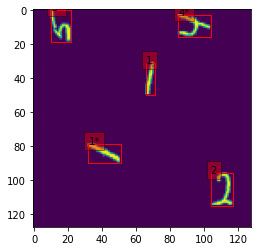

MODEL PREDICTION:


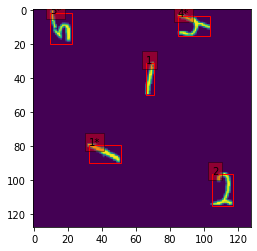

In [47]:
plot_answers(good, 0)

GROUNDTRUTH:


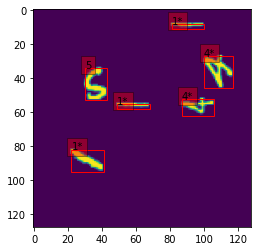

MODEL PREDICTION:


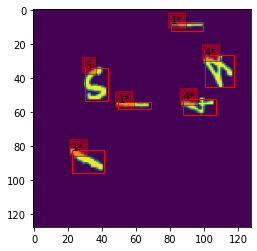

In [48]:
plot_answers(good, 1)

Eyeballing correct and wrong predictions digit '1' was very common to be accurately predicted by the model, there just isn't a digit close looking to it.

## Wrong predictions

GROUNDTRUTH:


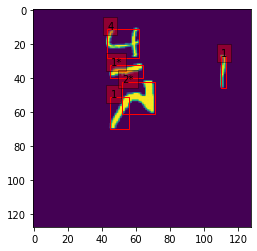

MODEL PREDICTION:


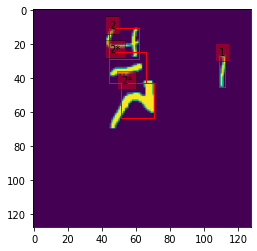

In [49]:
plot_answers(wrong, 1)

GROUNDTRUTH:


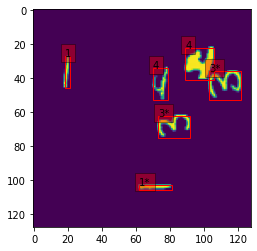

MODEL PREDICTION:


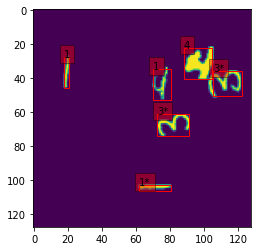

In [50]:
plot_answers(wrong, 7)

GROUNDTRUTH:


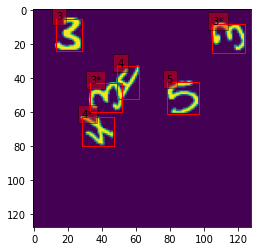

MODEL PREDICTION:


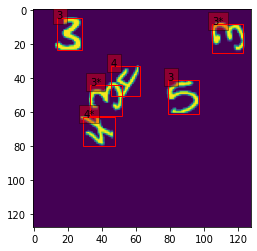

In [51]:
plot_answers(wrong, 11)

Most commonly model was very confused between when deciding between digits '3' and '5', but also canvas generation wasn't perfect, there were some peculiar cases when (as in first plot) when digits '2' and '1' were concatenated creating oddly looking '2'.